In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [31]:
df = pd.read_csv('./data/Imbalanced datasets SMOTE results.csv')
df = df.drop(columns=['model_category', 'perc_pred_missing'])
df.head()

,algorithm,dataset,accuracy,f1_score,precision,recall,auc_score,scenario
0,rt_bin_class_adaboost_sklearn,abalone,0.7440,0.3851,0.2538,0.7976,0.8545,smote
1,rt_bin_class_catboost,abalone,0.7955,0.3958,0.2814,0.6667,0.8621,smote
2,rt_bin_class_decision_tree_sklearn,abalone,0.8493,0.2500,0.2500,0.2500,0.5831,smote
3,rt_bin_class_ebm_interpretml,abalone,0.8624,0.3915,0.3524,0.4405,0.8316,smote
4,rt_bin_class_extra_trees_sklearn,abalone,0.8756,0.2973,0.3438,0.2619,0.8351,smote


In [51]:
# List of metrics to analyze
metrics = ['accuracy', 'f1_score', 'precision', 'recall', 'auc_score']

# Store results in a dictionary
better_scenario_percentage = {}

# Group by dataset and algorithm
grouped = df.groupby(['dataset', 'algorithm'])

# For each metric, compare the scores between the two scenarios
for metric in metrics:
    count_better_no_smote = 0
    count_better_smote = 0
    
    for _, group in grouped:
        no_smote_value = group[group['scenario'] == 'no-smote'][metric].values[0]
        smote_value = group[group['scenario'] == 'smote'][metric].values[0]
        
        if no_smote_value > smote_value:
            count_better_no_smote += 1
        elif smote_value > no_smote_value:
            count_better_smote += 1
    
    # Calculate percentages
    total_models = count_better_no_smote + count_better_smote
    better_scenario_percentage[metric] = {
        'no-smote': (count_better_no_smote / total_models) * 100,
        'smote': (count_better_smote / total_models) * 100
    }
print(better_scenario_percentage)


{'accuracy': {'no-smote': 80.69164265129683, 'smote': 19.30835734870317}, 'f1_score': {'no-smote': 41.03260869565217, 'smote': 58.96739130434783}, 'precision': {'no-smote': 73.81615598885793, 'smote': 26.18384401114206}, 'recall': {'no-smote': 14.97005988023952, 'smote': 85.02994011976048}, 'auc_score': {'no-smote': 58.448753462603875, 'smote': 41.55124653739612}}


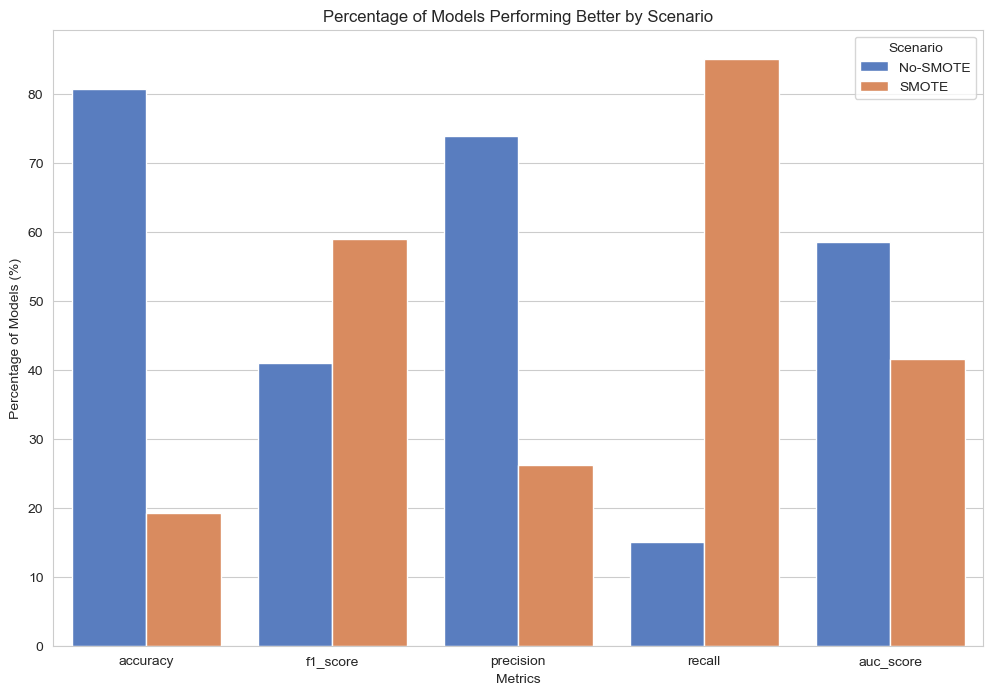

In [70]:
# Prepare the data for Seaborn
no_smote_percentages = [better_scenario_percentage[metric]['no-smote'] for metric in metrics]
smote_percentages = [better_scenario_percentage[metric]['smote'] for metric in metrics]

df_plot = pd.DataFrame({
    'Metrics': metrics * 2,
    'Percentage of Models (%)': no_smote_percentages + smote_percentages,
    'Scenario': ['No-SMOTE'] * len(metrics) + ['SMOTE'] * len(metrics)
})

# Set up the Seaborn style and plot size
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

# Create the bar plot using Seaborn
sns.barplot(x="Metrics", y="Percentage of Models (%)", hue="Scenario", data=df_plot, palette="muted")

# Display the plot title
plt.title('Percentage of Models Performing Better by Scenario')

plt.show()


## Imbalanced datasets

In [71]:
# Set up the figure to display multiple plots
def barchart(data):
    fig, axes = plt.subplots(nrows=len(metrics), figsize=(15, 5 * len(metrics)))

    # For each metric, create a bar chart showing the percentage of better-performing models by dataset
    for idx, metric in enumerate(metrics):
        # Group by dataset and algorithm, and compare the scores between the two scenarios for the specific metric
        better_count_per_dataset_metric = {}
        
        for (dataset, algorithm), group in data.groupby(['dataset', 'algorithm']):
            no_smote_value = group[group['scenario'] == 'no-smote'][metric].values[0]
            smote_value = group[group['scenario'] == 'smote'][metric].values[0]
            
            if dataset not in better_count_per_dataset_metric:
                better_count_per_dataset_metric[dataset] = {'no-smote': 0, 'smote': 0}
            
            if no_smote_value > smote_value:
                better_count_per_dataset_metric[dataset]['no-smote'] += 1
            elif smote_value > no_smote_value:
                better_count_per_dataset_metric[dataset]['smote'] += 1

        # Calculate the percentage of better-performing models for the specific metric
        better_percentage_per_dataset_metric = {}
        for dataset, counts in better_count_per_dataset_metric.items():
            total = counts['no-smote'] + counts['smote']
            if total == 0:
                better_percentage_per_dataset_metric[dataset] = {'no-smote': 0, 'smote': 0}
            else:
                better_percentage_per_dataset_metric[dataset] = {
                    'no-smote': (counts['no-smote'] / total) * 100,
                    'smote': (counts['smote'] / total) * 100
                }
        
        # Convert the results into a DataFrame for visualization
        df_better_percentage_metric = pd.DataFrame(better_percentage_per_dataset_metric).T.reset_index().melt(id_vars="index")
        # Plot the data using Seaborn's barplot
        sns.barplot(x="index", y="value", hue="variable", data=df_better_percentage_metric, palette="muted", ax=axes[idx])
        axes[idx].set_title(f"Percentage of Better-Performing Models by Dataset for {metric}")
        axes[idx].set_xlabel("Dataset")
        axes[idx].set_ylabel("Percentage of Better Models (%)")
        axes[idx].tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()

## Imbalanced datasets

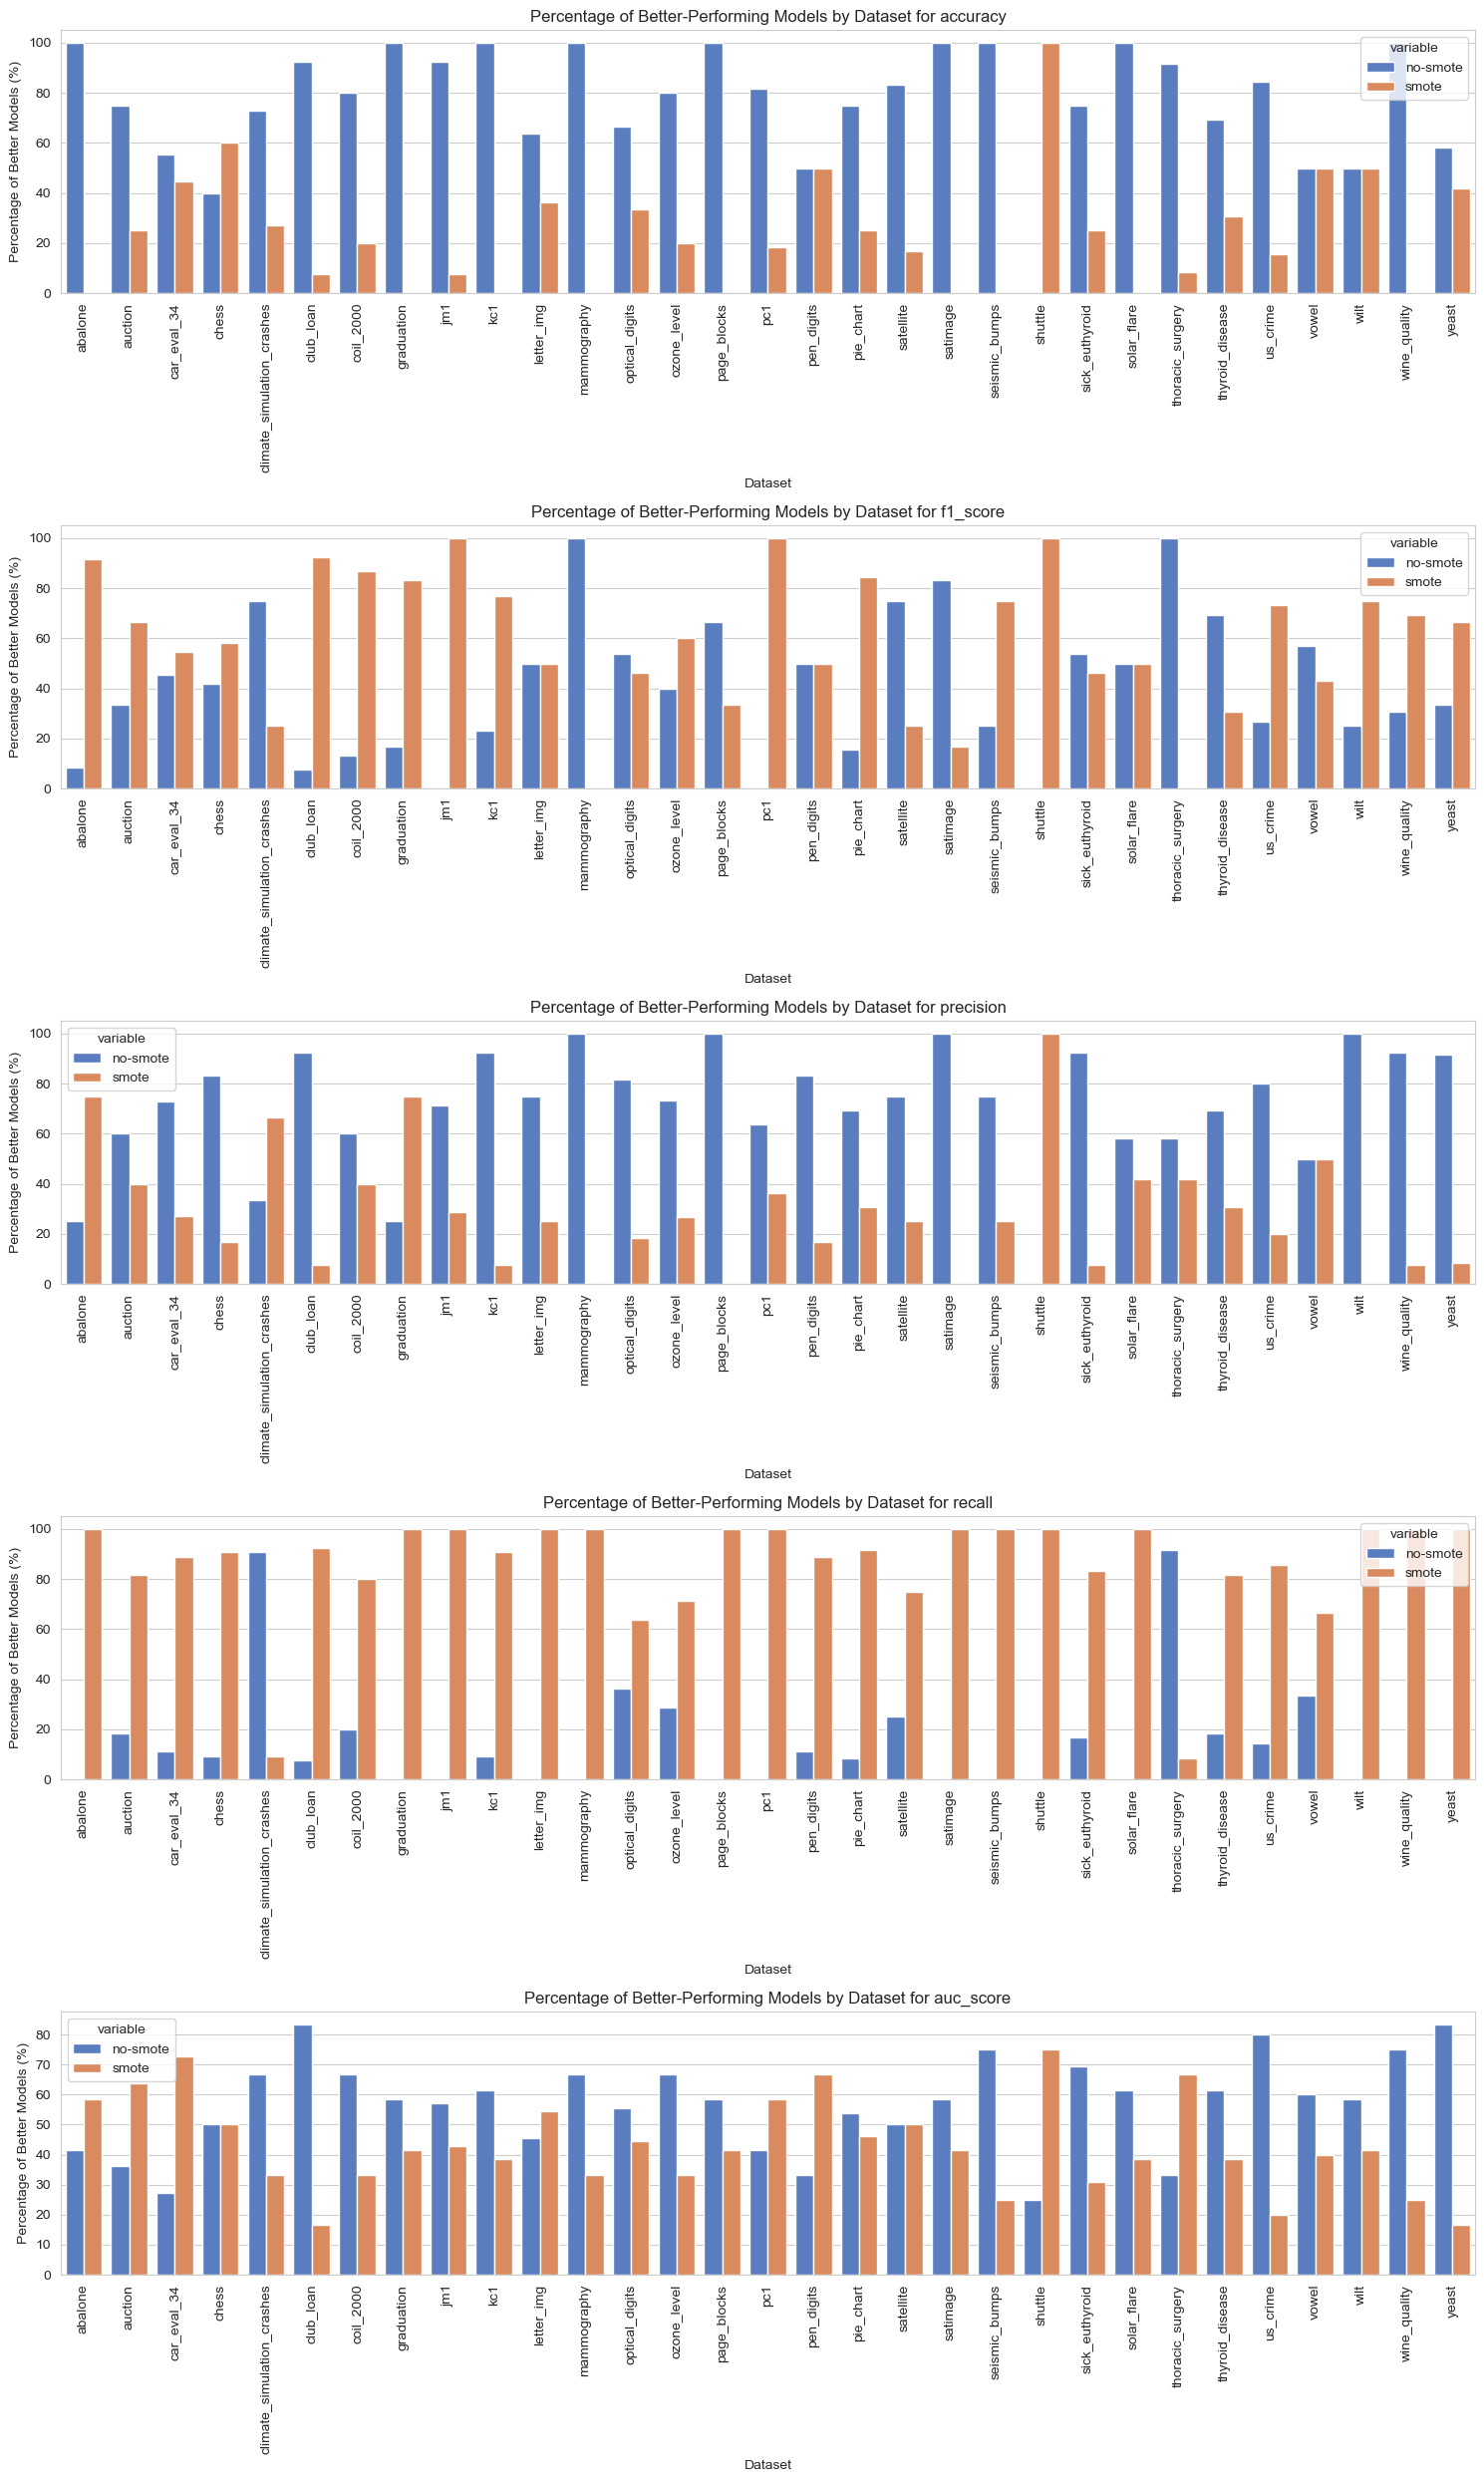

In [72]:
barchart(df)

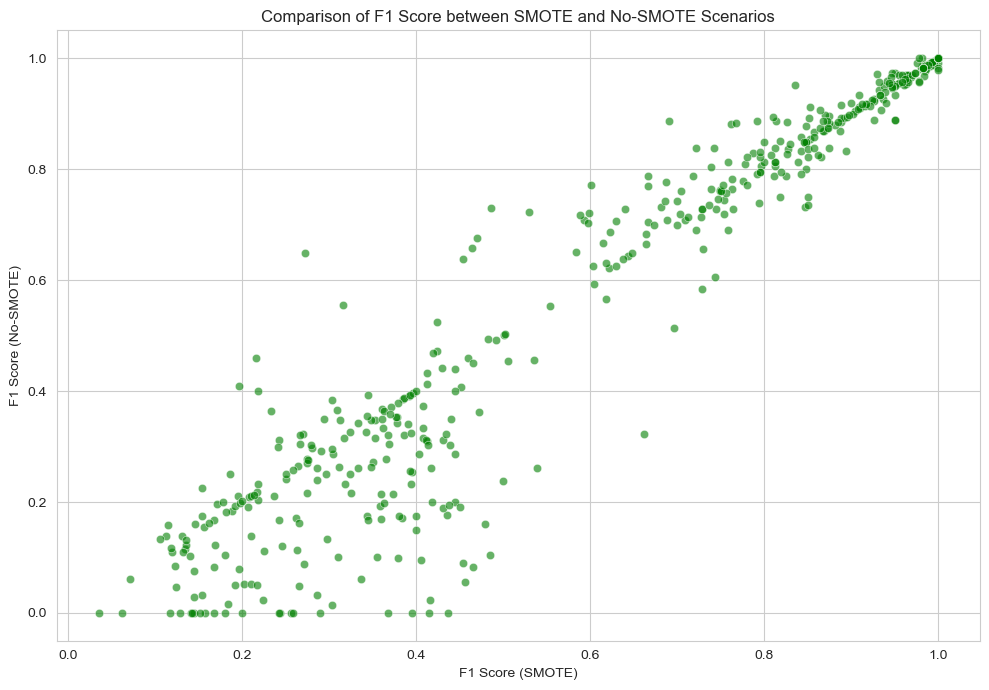

In [73]:
# Separate the data into "SMOTE" and "No-SMOTE" scenarios
smote_data = df[df['scenario'] == 'smote'].rename(columns={'f1_score': 'f1_score_smote', 'accuracy': 'accuracy_smote', 'recall': 'recall_smote', 'precision': 'precision_smote', 'auc_score': 'auc_score_smote'})
no_smote_data = df[df['scenario'] == 'no-smote'].rename(columns={'f1_score': 'f1_score_no_smote', 'accuracy': 'accuracy_no_smote', 'recall': 'recall_no_smote', 'precision': 'precision_no_smote', 'auc_score': 'auc_score_no_smote'})

merged_data = pd.merge(smote_data, no_smote_data, on=['dataset', 'algorithm'])

# Plot the scatter plot
plt.figure(figsize=(10, 7))
sns.scatterplot(data=merged_data, 
                x="f1_score_smote", 
                y="f1_score_no_smote",
                alpha=0.6, 
                color="green",
                edgecolor="w")

plt.title("Comparison of F1 Score between SMOTE and No-SMOTE Scenarios")
plt.xlabel("F1 Score (SMOTE)")
plt.ylabel("F1 Score (No-SMOTE)")

plt.tight_layout()
plt.show()



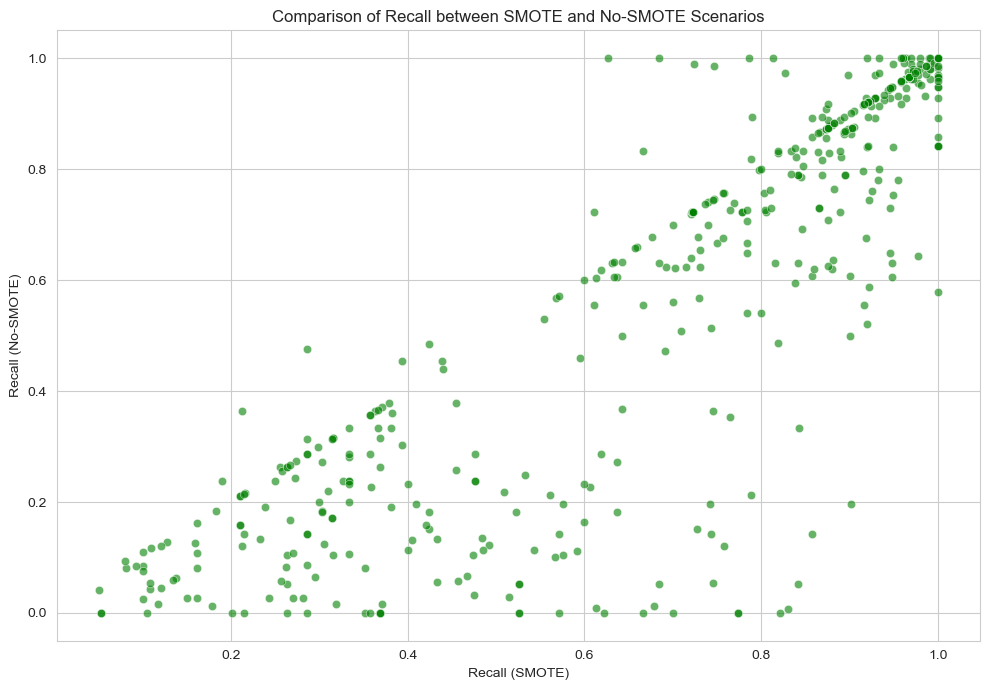

In [74]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=merged_data, 
                x="recall_smote", 
                y="recall_no_smote",
                alpha=0.6, 
                color="green",
                edgecolor="w")

plt.title("Comparison of Recall between SMOTE and No-SMOTE Scenarios")
plt.xlabel("Recall (SMOTE)")
plt.ylabel("Recall (No-SMOTE)")

plt.tight_layout()
plt.show()



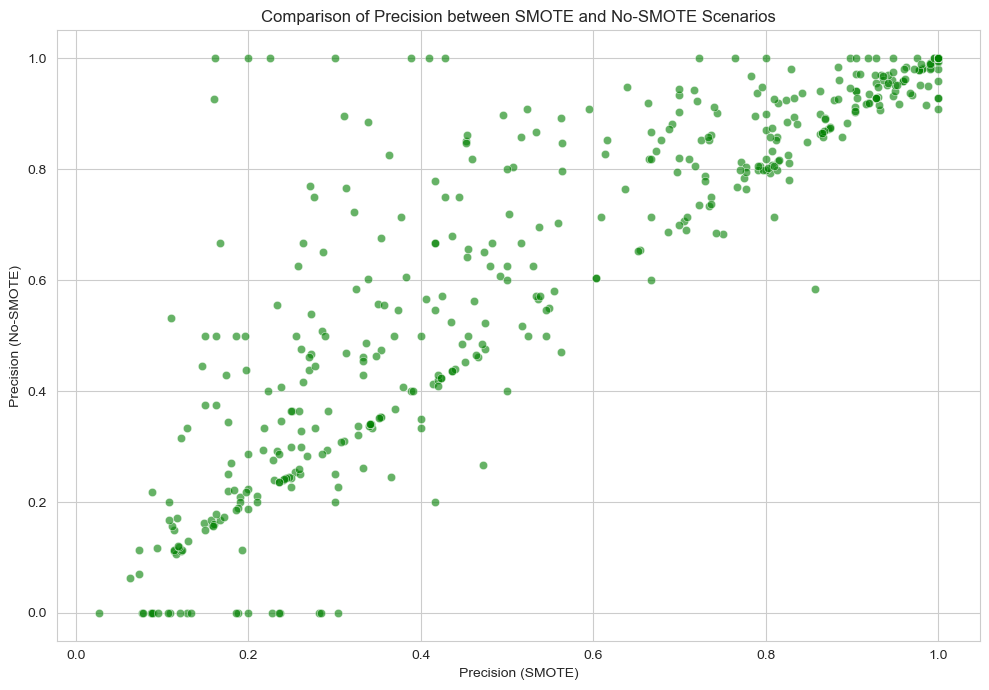

In [75]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=merged_data, 
                x="precision_smote", 
                y="precision_no_smote",
                alpha=0.6, 
                color="green",
                edgecolor="w")

plt.title("Comparison of Precision between SMOTE and No-SMOTE Scenarios")
plt.xlabel("Precision (SMOTE)")
plt.ylabel("Precision (No-SMOTE)")

plt.tight_layout()
plt.show()

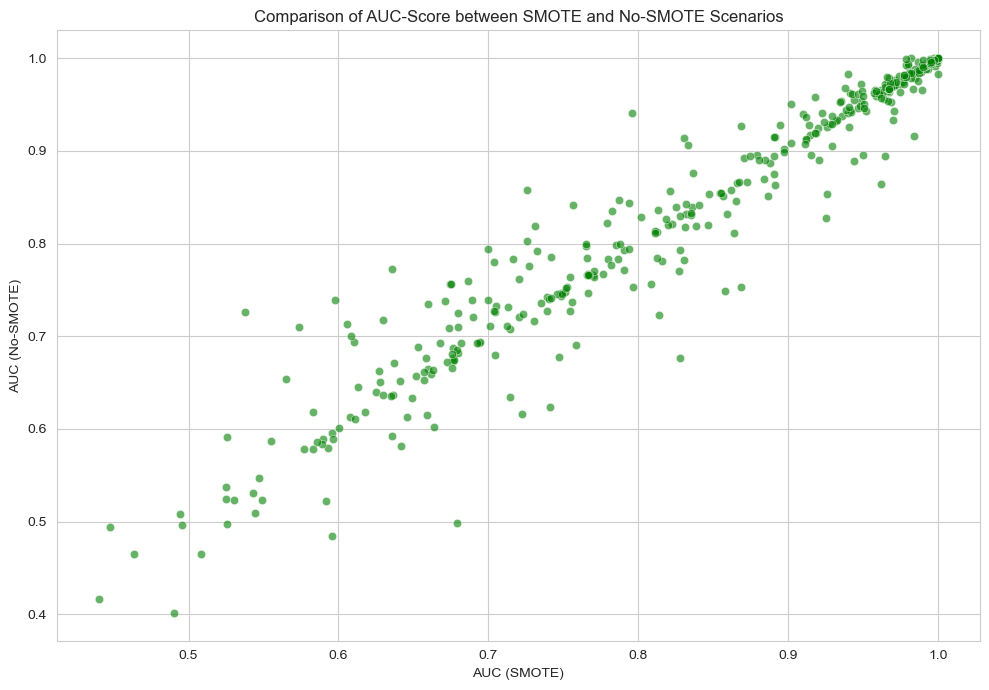

In [76]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=merged_data, 
                x="auc_score_smote", 
                y="auc_score_no_smote",
                alpha=0.6, 
                color="green",
                edgecolor="w")

plt.title("Comparison of AUC-Score between SMOTE and No-SMOTE Scenarios")
plt.xlabel("AUC (SMOTE)")
plt.ylabel("AUC (No-SMOTE)")

plt.tight_layout()
plt.show()

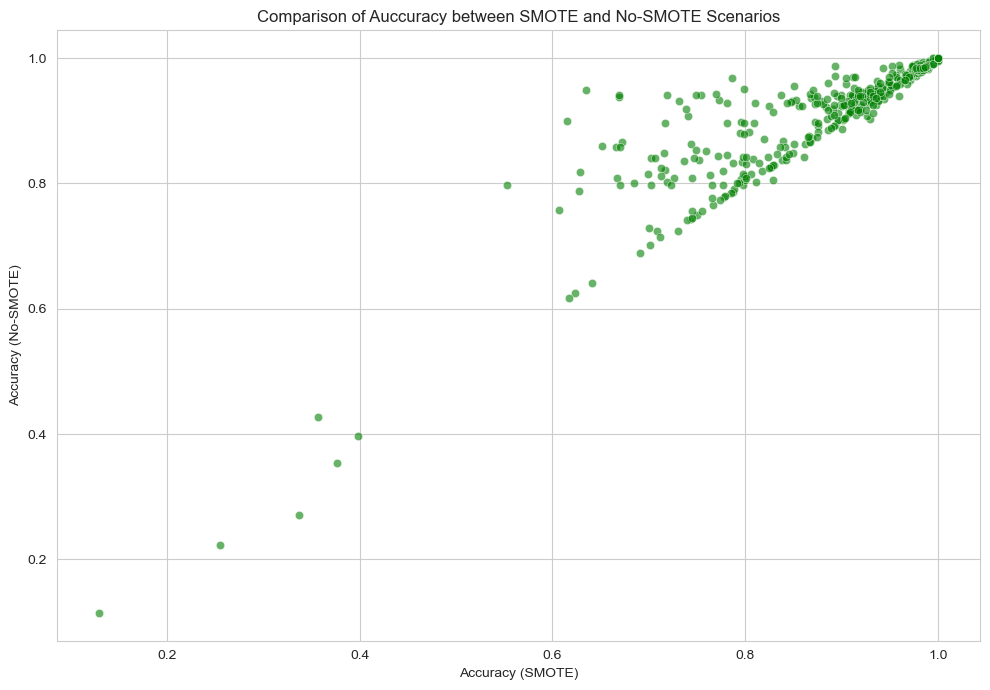

In [77]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=merged_data, 
                x="accuracy_smote", 
                y="accuracy_no_smote",
                alpha=0.6, 
                color="green",
                edgecolor="w")

plt.title("Comparison of Auccuracy between SMOTE and No-SMOTE Scenarios")
plt.xlabel("Accuracy (SMOTE)")
plt.ylabel("Accuracy (No-SMOTE)")

plt.tight_layout()
plt.show()

In [78]:
# Group by dataset and scenario, then compute the average for each metric
averaged_metrics = df.drop(columns=['algorithm']).groupby(['dataset', 'scenario']).mean().reset_index()

# Pivot the data so that we have one row for each dataset and columns for each scenario
pivoted_metrics = averaged_metrics.pivot(index='dataset', columns='scenario').reset_index()

differences = {}
for metric in ['accuracy', 'f1_score', 'precision', 'recall', 'auc_score']:
    no_smote_col = (metric, 'no-smote')
    with_smote_col = (metric, 'smote')
    differences[metric] = pivoted_metrics[with_smote_col] - pivoted_metrics[no_smote_col]

differences_df = pd.DataFrame(differences)


In [79]:
pivoted_metrics.head()

dataset  accuracy            f1_score            \
scenario                              no-smote     smote  no-smote     smote   
0                            abalone  0.864973  0.813953  0.159580  0.354507   
1                            auction  0.932033  0.902693  0.691927  0.741067   
2                        car_eval_34  0.967420  0.963387  0.828647  0.822020   
3                              chess  0.982787  0.983140  0.816987  0.830947   
4         climate_simulation_crashes  0.927153  0.911113  0.960527  0.949500   

         precision              recall           auc_score            
scenario  no-smote     smote  no-smote     smote  no-smote     smote  
0         0.213487  0.295167  0.201587  0.538093  0.810273  0.808273  
1         0.776907  0.718887  0.664240  0.810913  0.917740  0.925520  
2         0.771873  0.727233  0.919060  0.964287  0.986213  0.989700  
3         0.827687  0.764827  0.863167  0.947367  0.987187  0.980700  
4         0.946193  0.959113  0.976200  0.943553  0.927540  0.936087

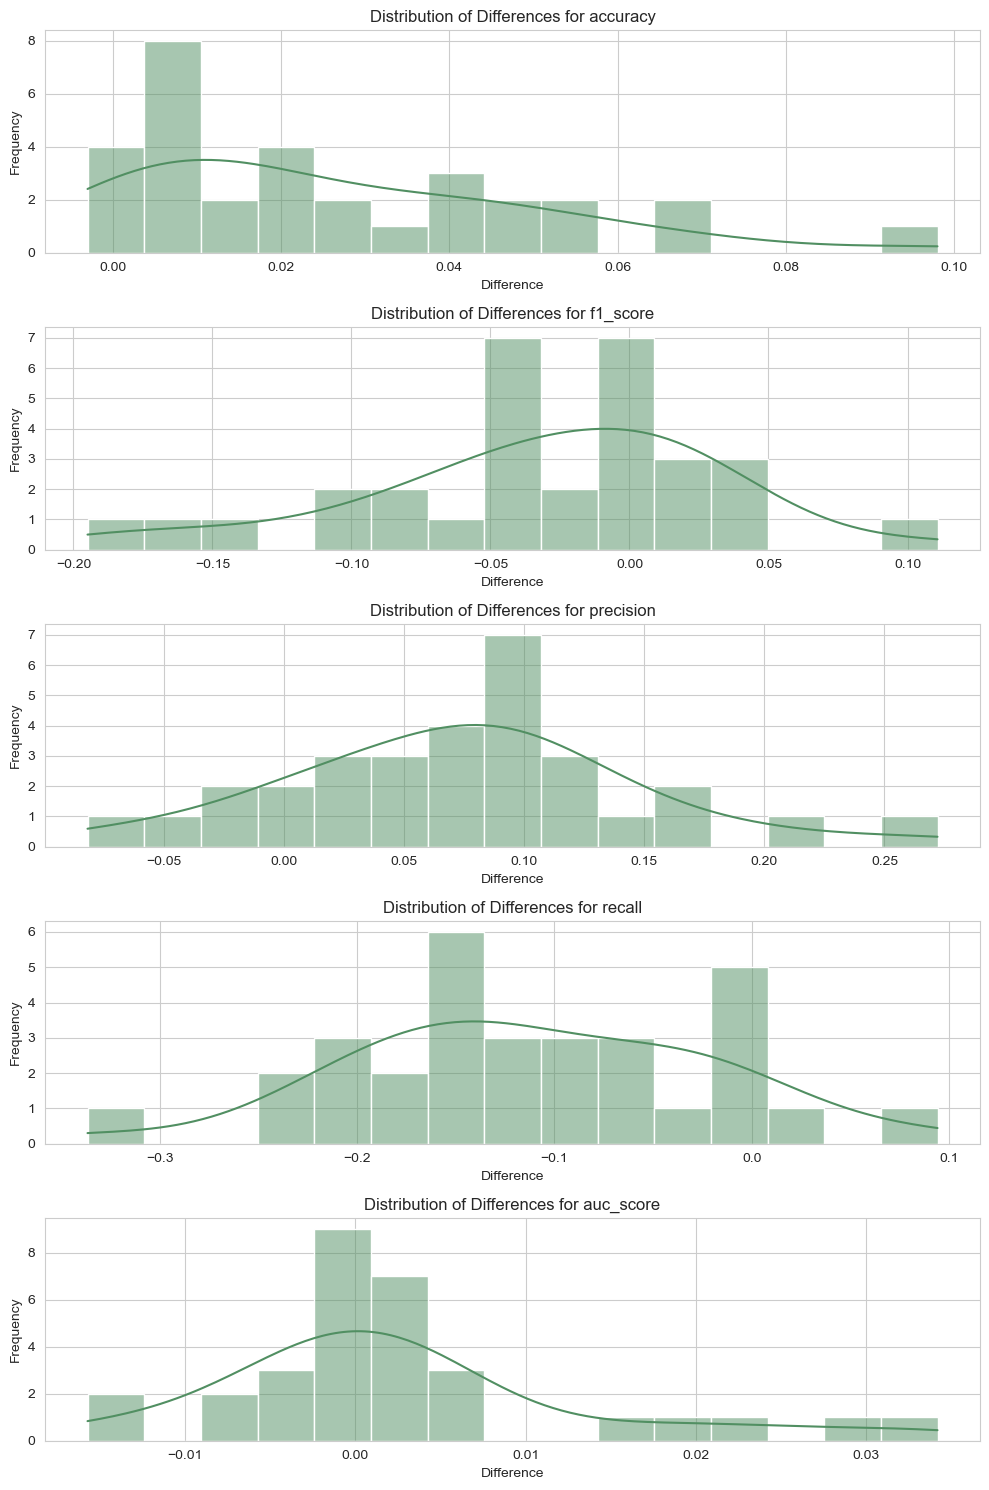

In [80]:
# Plot histograms for the differences
fig, axes = plt.subplots(nrows=len(metrics), ncols=1, figsize=(10, 15))

for i, metric in enumerate(metrics):
    no_smote_data = pivoted_metrics[metric]['no-smote'].astype(float)
    smote_data = pivoted_metrics[metric]['smote'].astype(float)
    differences = no_smote_data - smote_data

    sns.histplot(differences, bins=15, kde=True, ax=axes[i], color='#518f62')
    axes[i].set_title(f"Distribution of Differences for {metric}")
    axes[i].set_xlabel("Difference")
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


In [81]:
from scipy.stats import wilcoxon

wilcoxon_results = {}
for metric in metrics:
    stat, p_value = wilcoxon(differences_df[metric])
    wilcoxon_results[metric] = {'Statistic': stat, 'P-Value': p_value}

wilcoxon_results = pd.DataFrame(wilcoxon_results).T
wilcoxon_results

,Statistic,P-Value
accuracy,6.0,0.000002
f1_score,133.0,0.024221
precision,34.0,0.000027
recall,19.0,0.000007
auc_score,194.0,0.289958


In [82]:
from scipy.stats import ttest_rel

ttest_results = {}
for metric in metrics:
    no_smote_data = pivoted_metrics[metric]['no-smote'].astype(float)
    smote_data = pivoted_metrics[metric]['smote'].astype(float)
    stat, p_value = ttest_rel(no_smote_data, smote_data)
    ttest_results[metric] = {'Statistic': stat, 'P-Value': p_value}

ttest_results = pd.DataFrame(ttest_results).T
ttest_results


,Statistic,P-Value
accuracy,5.984707,1.455182e-06
f1_score,-2.644405,1.289257e-02
precision,5.616030,4.095170e-06
recall,-6.775046,1.635219e-07
auc_score,1.427832,1.636681e-01


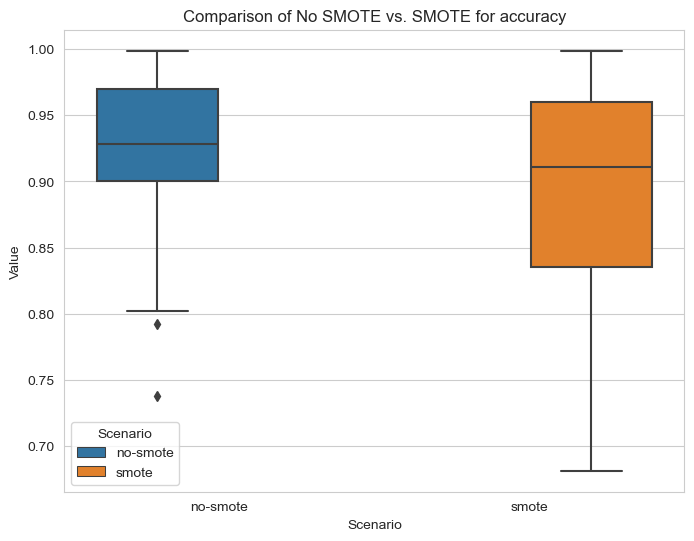

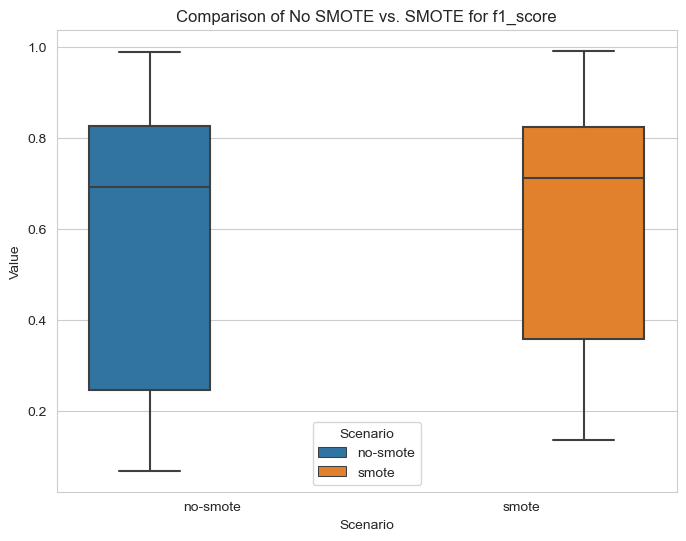

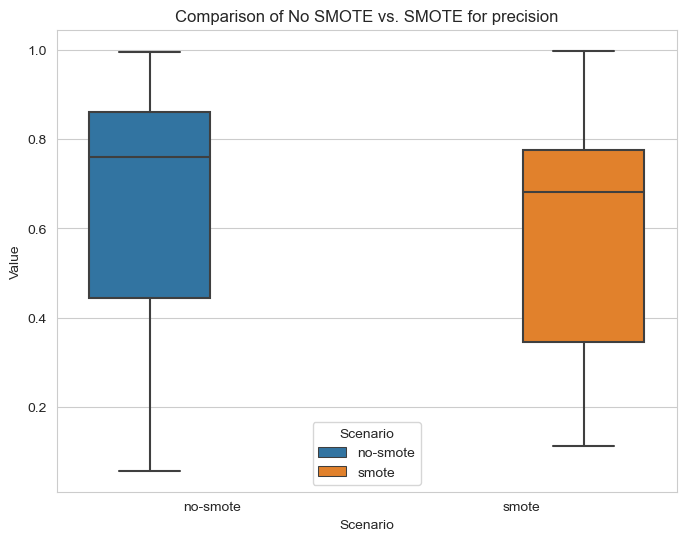

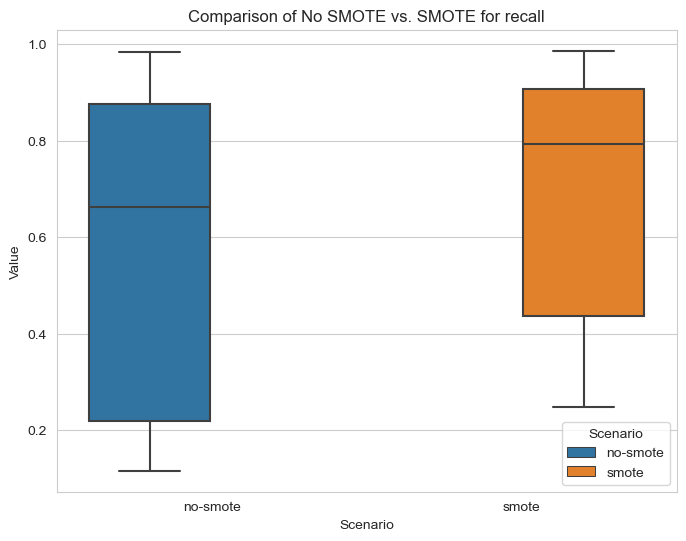

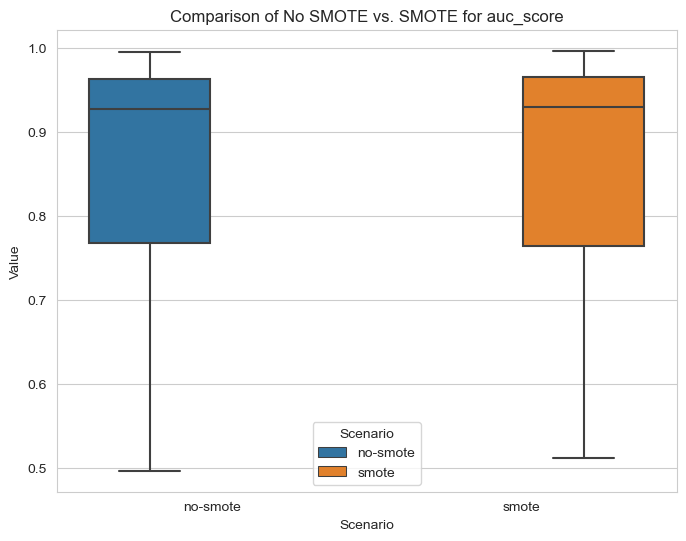

In [83]:
for metric in metrics:
    melted_data = pivoted_metrics[metric].melt(var_name='Scenario', value_name='Value')

    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Scenario', y='Value', data=melted_data, hue='Scenario')
    plt.title(f"Comparison of No SMOTE vs. SMOTE for {metric}")
    plt.show()

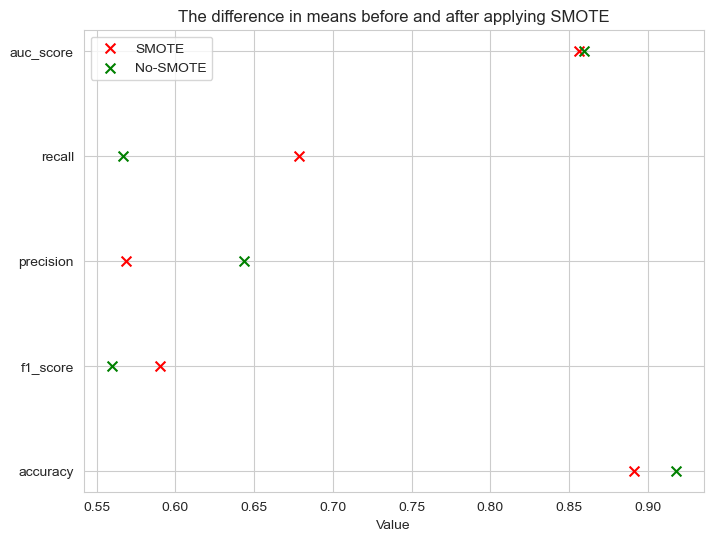

In [84]:
# Create the dot plot
fig, ax = plt.subplots(figsize=(8, 6))
values1 = [pivoted_metrics[i]['smote'].mean() for i in metrics]
values2 = [pivoted_metrics[i]['no-smote'].mean() for i in metrics]

# Plotting for the two sets of data
ax.scatter(values1, metrics, color='red', label='SMOTE', s=50, marker='x')
ax.scatter(values2, metrics, color='green', label='No-SMOTE', s=50, marker='x')

# Setting labels and title
ax.set_xlabel('Value')
ax.set_title('The difference in means before and after applying SMOTE')
ax.legend()

plt.show()


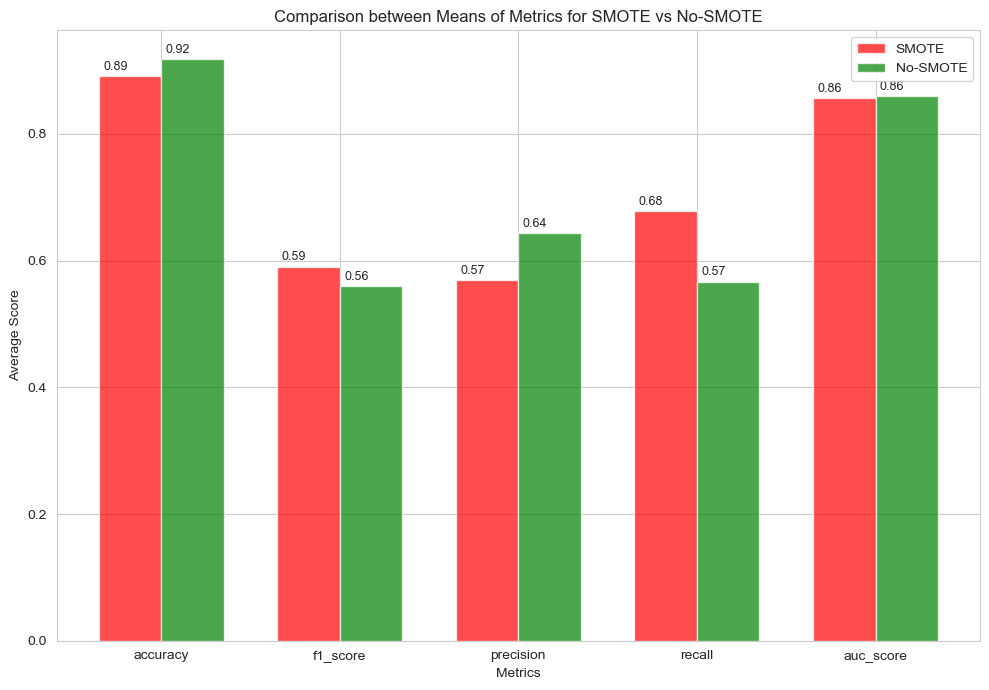

In [85]:
# Set up the bar positions and width
bar_width = 0.35
index = range(len(metrics))

fig, ax = plt.subplots(figsize=(10, 7))

# Create bars for both conditions
bar1 = ax.bar(index, values1, bar_width, label='SMOTE', color='red', alpha=0.7)
bar2 = ax.bar([i + bar_width for i in index], values2, bar_width, label='No-SMOTE', color='green', alpha=0.7)

# Annotate the bar values
for bar, value in zip(bar1, values1):
    ax.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 0.01, f"{value:.2f}", fontsize=9)
for bar, value in zip(bar2, values2):
    ax.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 0.01, f"{value:.2f}", fontsize=9)

# Set the x-axis labels, title, and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('Average Score')
ax.set_title('Comparison between Means of Metrics for SMOTE vs No-SMOTE')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()


In [86]:
def cohen_d(mean1, mean2, std1, std2, n1, n2):
    """
    Calculate Cohen's d for comparing two groups.
    
    Parameters:
    - mean1, mean2: means of the two groups
    - std1, std2: standard deviations of the two groups
    - n1, n2: sample sizes of the two groups
    
    Returns:
    - Cohen's d value
    """
    # Calculate the pooled standard deviation
    sp = ((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2)
    sp = sp**0.5
    
    # Calculate Cohen's d
    d = (mean1 - mean2) / sp
    return d




In [87]:
results = {}
for metric in metrics:
    smote_mean = pivoted_metrics[metric]['smote'].mean()
    no_smote_mean = pivoted_metrics[metric]['no-smote'].mean()
    smote_std = pivoted_metrics[metric]['smote'].std()
    no_smote_std = pivoted_metrics[metric]['no-smote'].std()
    n1 = len(pivoted_metrics[metric]['smote'])
    n2 = len(pivoted_metrics[metric]['no-smote'])
    cohen = cohen_d(smote_mean, no_smote_mean, smote_std, no_smote_std, n1, n2)
    results[metric] = cohen
results

{'accuracy': -0.3483615540002201,
 'f1_score': 0.10439013568288769,
 'precision': -0.27691990177521025,
 'recall': 0.38467813193398437,
 'auc_score': -0.0210199748341544}